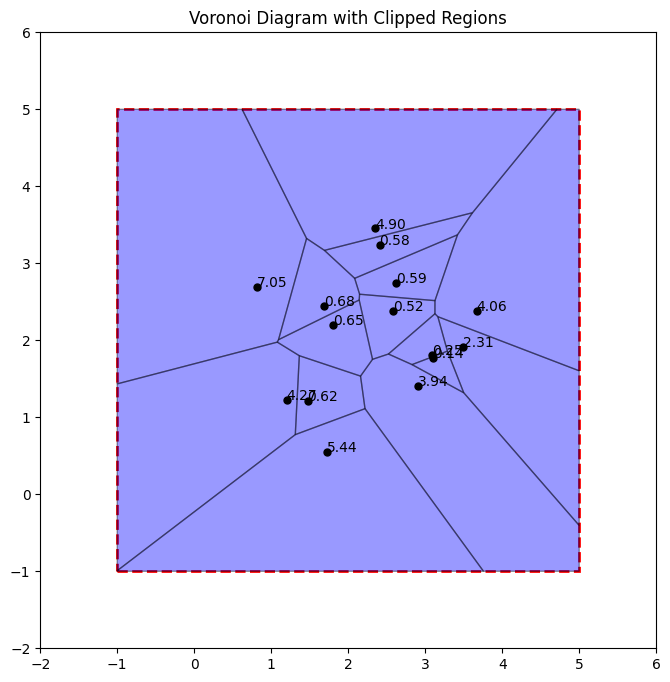

[0.5181058228794879, 0.5866334297422544, 7.047328118836863, 2.3095199605754924, 0.2532402000343737, 0.5816844031019637, 0.6158366817352326, 4.268626353784712, 3.935626654972906, 4.0623650126709965, 4.898679057521836, 0.653862632928091, 0.1424576189307613, 0.6814870381549132, 5.444547014130118]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from matplotlib.patches import Polygon as MplPolygon
from shapely.geometry import Polygon as ShapelyPolygon

# Generate points in the grid between (0,0) and (3,3)
# points = np.array([[x, y] for x in range(4) for y in range(4)])
# points = np.vstack([points, [[4.5,4.5], [4.3, 4.2], [4.1, 4.6]]])

points = np.random.randn(15,2) + np.array([2,2])
points.clip(min=-1, max=5)
# Calculate the Voronoi diagram
vor = Voronoi(points)

# Function to reconstruct infinite Voronoi regions into finite polygons
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstructs infinite Voronoi regions in a 2D diagram to finite regions.

    Parameters:
    vor : Voronoi
        Voronoi diagram to process
    radius : float, optional
        Distance to 'points at infinity'

    Returns:
    regions : list of lists of int
        Indices of vertices in each revised Voronoi region
    vertices : ndarray
        Coordinates for revised Voronoi vertices
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    # Ensure we have a radius to 'points at infinity'
    if radius is None:
        radius = np.ptp(vor.points).max() * 2

    # Center of the Voronoi diagram
    center = vor.points.mean(axis=0)

    # Map of all ridges for each point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct the finite regions
    new_regions = []
    new_vertices = vor.vertices.tolist()
    for p1, region_idx in enumerate(vor.point_region):
        vertices = vor.regions[region_idx]
        if all(v >= 0 for v in vertices):
            # Finite region
            new_regions.append(vertices)
            continue

        # Reconstruct infinite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            # Infinite ridge
            if v2 < 0:
                v1, v2 = v2, v1

            if v1 >= 0:
                # Finite ridge
                continue

            # Compute the missing endpoint
            t = vor.points[p2] - vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n

            far_point = vor.vertices[v2] + direction * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        # Sort region counterclockwise
        vs = np.array([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]
        new_regions.append(new_region.tolist())

    return new_regions, np.array(new_vertices)

# Define the bounding box
bounding_box = ShapelyPolygon([(-1, -1), (5, -1), (5, 5), (-1, 5)])

# Get the finite Voronoi regions and vertices
regions, vertices = voronoi_finite_polygons_2d(vor)

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the original points
ax.plot(points[:, 0], points[:, 1], 'ko', markersize=5)

# Add the bounding box as a polygon
bounding_patch = MplPolygon(list(bounding_box.exterior.coords), closed=True, fill=None, edgecolor='red', linewidth=2, linestyle='--')
ax.add_patch(bounding_patch)

# Store the areas of the clipped Voronoi regions
clipped_areas = []

# Iterate over each Voronoi region and calculate the clipped area
for region in regions:
    polygon_points = vertices[region]
    voronoi_polygon = ShapelyPolygon(polygon_points)

    # Clip the Voronoi polygon by the bounding box
    clipped_polygon = voronoi_polygon.intersection(bounding_box)

    if not clipped_polygon.is_empty:
        # For MultiPolygon, sum the areas and plot each part
        if clipped_polygon.geom_type == 'Polygon':
            area = clipped_polygon.area
            clipped_areas.append(area)

            # Plot the clipped polygon
            polygon_patch = MplPolygon(list(clipped_polygon.exterior.coords), closed=True, fill=True, facecolor='blue', edgecolor='black', alpha=0.4)
            ax.add_patch(polygon_patch)

        elif clipped_polygon.geom_type == 'MultiPolygon':
            area = 0
            for poly in clipped_polygon:
                area += poly.area
                polygon_patch = MplPolygon(list(poly.exterior.coords), closed=True, fill=True, facecolor='blue', edgecolor='black', alpha=0.4)
                ax.add_patch(polygon_patch)
            clipped_areas.append(area)
    else:
        clipped_areas.append(0)

# Set the axis limits
ax.set_xlim(-2, 6)
ax.set_ylim(-2, 6)
ax.set_aspect('equal')

plt.title('Voronoi Diagram with Clipped Regions')
for i,p in enumerate(points):
    ax.text(p[0], p[1], f"{clipped_areas[i]:.2f}")
plt.show()

# Display the clipped areas
print(clipped_areas)



In [2]:
np.sum(clipped_areas)

np.float64(36.0)

In [3]:
points.shape

(15, 2)

In [4]:
# Try 3d

import numpy as np
from scipy.spatial import Voronoi, ConvexHull

# Generate random 3D points
points = np.random.randn(20, 3)
points = points[np.linalg.norm(points, axis=1) < 3] 
# Compute 3D Voronoi diagram
vor = Voronoi(points)

# List to store volumes
volumes = []

# Iterate through each region
for region in vor.regions:
    if not -1 in region and len(region) > 0:
        # Compute the convex hull of the region vertices
        hull = ConvexHull(vor.vertices[region])
        # Store the volume of the region
        volumes.append(hull.volume)

# Display volumes
print(volumes)


[6.909972780703679, 0.5266186708071916, 3.075027661818372, 2.513706328092592, 15.251095495025167, 8.509524175781033]


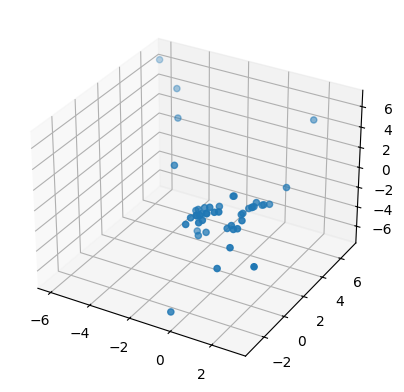

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the Voronoi vertices
ax.scatter(vor.vertices[:, 0], vor.vertices[:, 1], vor.vertices[:, 2])

plt.show()


In [6]:
%matplotlib notebook


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# 3D Plotting Tools
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Generate random 3D points
points = np.random.rand(15, 3)

# Compute 3D Voronoi diagram
vor = Voronoi(points)

# Set up a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the original points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='r', s=50)

# Plot the Voronoi vertices
ax.scatter(vor.vertices[:, 0], vor.vertices[:, 1], vor.vertices[:, 2], color='b', s=20)

# Plot edges of Voronoi regions
for ridge in vor.ridge_vertices:
    # Skip regions that extend to infinity (-1 in ridge vertices)
    if -1 in ridge:
        continue
    # Get the two vertices of each ridge
    ridge_vertices = vor.vertices[ridge]
    ax.plot(ridge_vertices[:, 0], ridge_vertices[:, 1], ridge_vertices[:, 2], 'k-')

# Label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


<IPython.core.display.Javascript object>